In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Bu bölümde projede kullanılacak temel Python kütüphaneleri import edilmiştir.
        
# Ayrıca, Kaggle ortamında verinin bulunduğu dizin ../input/... şeklinde tanımlanmakta,
# bu nedenle veri seti uygun şekilde bu dizinden okunmuştur.

/kaggle/input/hospital-length-of-stay-dataset-microsoft/LengthOfStay.csv


# Hasta Kalma Süresi Tahmini

Bu projede, hastaların hastanede kalma sürelerini tahmin etmeye çalışıyoruz. Kullanılan yöntemler arasında veri temizleme, keşifsel veri analizi (EDA) ve Random Forest Regressor ile modelleme yer alıyor. Proje küçük bir örneklem üzerinde yürütülmüş olup başarılı sonuçlar elde edilmiştir.


## 1. Veri Yükleme ve İnceleme

Veri dosyamızı yüklüyoruz ve ilk birkaç satırına göz atıyoruz. Eksik veri olup olmadığını kontrol ediyoruz.


In [2]:

# Veri setini oku
df = pd.read_csv("/kaggle/input/hospital-length-of-stay-dataset-microsoft/LengthOfStay.csv")

# İlk 5 satırı görüntüle
df.head()


,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [3]:
# Veri kümesinin genel bilgileri
df.info()

# Eksik veri var mı kontrol edildi
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  object 
 3   gender                      100000 non-null  object 
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

eid                           0
vdate                         0
rcount                        0
gender                        0
dialysisrenalendstage         0
asthma                        0
irondef                       0
pneum                         0
substancedependence           0
psychologicaldisordermajor    0
depress                       0
psychother                    0
fibrosisandother              0
malnutrition                  0
hemo                          0
hematocrit                    0
neutrophils                   0
sodium                        0
glucose                       0
bloodureanitro                0
creatinine                    0
bmi                           0
pulse                         0
respiration                   0
secondarydiagnosisnonicd9     0
discharged                    0
facid                         0
lengthofstay                  0
dtype: int64

## 2. Sayısal ve Kategorik Veriler Kontrol Edildi


In [4]:
# Sayısal verilerin özet istatistikleri
df.describe()

# Kategorik sütunları görmek için
df.select_dtypes(include='object').nunique()


vdate         367
rcount          6
gender          2
discharged    378
facid           5
dtype: int64

## 3. Keşifsel Veri Analizi (EDA)
İki kod da Seaborn kütüphanesinin histplot fonksiyonunu kullanarak "lengthofstay" (kalış süresi) değişkeninin dağılımını histogram şeklinde çiziyor. 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


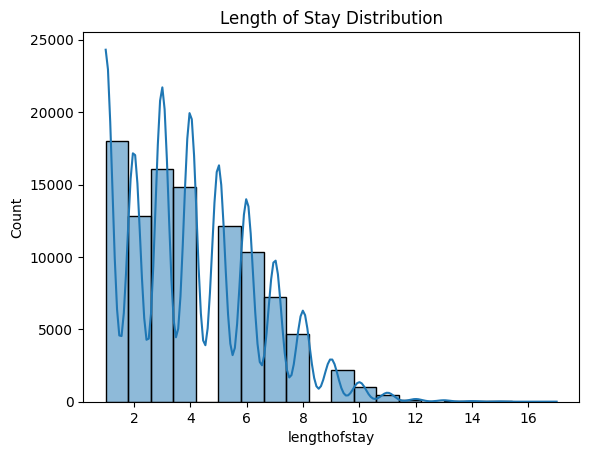

In [5]:
# Hedef değişkenin dağılımına bakıldı
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['lengthofstay'], bins=20, kde=True)
plt.title("Length of Stay Distribution")
plt.show()


İlk görselleştirme genel bir bakış almak için yapıldı.

Sonrasında:

Bin sayısı (bars) artırılarak daha detaylı bir analiz yapmak ve eksik olan eksen etiketleri eklenerek grafik sunuma hazır hale getirildi.

Bu şekilde görselleştirmenin temiz ve açıklayıcı olması sağlandı.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


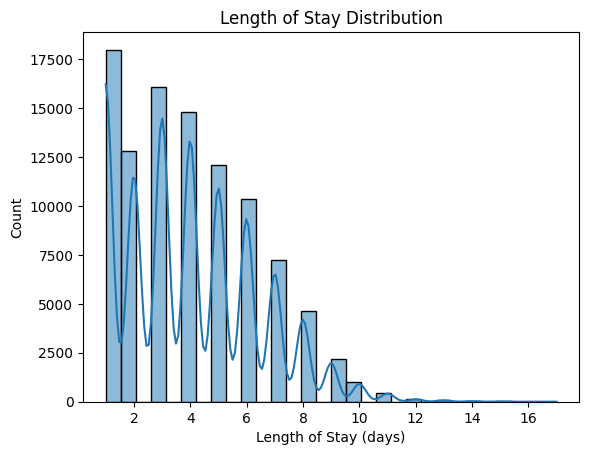

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['lengthofstay'], bins=30, kde=True)
# bins artırılarak daha detaylı bir analiz yapıldı
plt.title("Length of Stay Distribution")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Count")
plt.show()


## 4. Tarihleri datetime’a çevirme
Bu kısımda vdate ve discharged sütunları pandas datetime formatına çevrildi. Sonra da hastanın hastanede kaç gün kaldığı hesaplandı. Modelde ekstra özellik olarak kullanmak için.

In [10]:
# Tarih sütunlarını datetime formatına çevirme
df['vdate'] = pd.to_datetime(df['vdate'])
df['discharged'] = pd.to_datetime(df['discharged'])

# Hastanede kalış süresi (gün olarak)
df['stay_days'] = (df['discharged'] - df['vdate']).dt.days

# İlk 5 satırı kontrol et
print(df[['vdate', 'discharged', 'stay_days', 'lengthofstay']].head())


       vdate discharged  stay_days  lengthofstay
0 2012-08-29 2012-09-01          3             3
1 2012-05-26 2012-06-02          7             7
2 2012-09-22 2012-09-25          3             3
3 2012-08-09 2012-08-10          1             1
4 2012-12-20 2012-12-24          4             4


Burada stay_days ile lengthofstay sütunları birbirini tutuyor, yani veri tutarlı.

## 5. Hedef değişkeni ayarlama ve bazı sütunları temizleme
Bu kısımda regresyon için lengthofstay hedef değişken yapıldı.
Modelde kullanmak istenmeyen, ya da veriye katkısı olmayan sütunlar çıkarıldı.



In [11]:
# Model için hedef değişken
target = 'lengthofstay'

# Kullanmak istemediğim sütunlar
drop_cols = ['eid', 'vdate', 'discharged', 'stay_days']

# Özellikler (features)
X = df.drop(columns=drop_cols + [target])
y = df[target]

print("Kullanılacak özellikler:")
print(X.columns)


Kullanılacak özellikler:
Index(['rcount', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef',
       'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress',
       'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit',
       'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine',
       'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'facid'],
      dtype='object')


Kullanılabilecek 24 tane özellik var. Ama burada hem sayısal hem kategorik değişkenler var bu yüzden öncelikle veri tipini netleştirildi.

### Öncelikle 'rcount' sütununun içeriğine bakıldı.

In [12]:
print(X['rcount'].value_counts().head(10))
print(X['rcount'].dtype)


rcount
0     55031
1     15007
2      9987
3      8047
4      6941
5+     4987
Name: count, dtype: int64
object


Sonuca bakıldığında rcount sütununda "5+" gibi bir string var ve sütunun tipi object  
Bu yüzden:
"5+" değerleri 5 veya daha yüksek bir sayı ile değiştirildi (örneğin 5 veya 6 olarak).
Sonra sütun sayısal tipe çevirildi.

In [13]:
# "5+" değerlerini 5 olarak değiştir
X['rcount'] = X['rcount'].replace('5+', '5')

# Sonra sütunu integer tipine dönüştür
X['rcount'] = X['rcount'].astype(int)

# Tekrar kontrol edildi
print(X['rcount'].value_counts())
print("Yeni rcount tipi:", X['rcount'].dtype)



rcount
0    55031
1    15007
2     9987
3     8047
4     6941
5     4987
Name: count, dtype: int64
Yeni rcount tipi: int64


rcount sütunu sayısala çevrildi.

Sonraki adımda kategorik değişkenler sayısala çevirildi.
facid değişkeni birden fazla kategori içerebileceğinden dolayı one-hot encoding ile dönüştürüldü.



In [14]:
# gender sütunu sayısala çevrildi.
X['gender'] = X['gender'].map({'F':0, 'M':1})

# facid sütunu için one-hot encoding yapıldı.
X = pd.get_dummies(X, columns=['facid'], drop_first=True)

# Son hali 
print(X.head())
print(X.dtypes)


   rcount  gender  dialysisrenalendstage  asthma  irondef  pneum  \
0       0       0                      0       0        0      0   
1       5       0                      0       0        0      0   
2       1       0                      0       0        0      0   
3       0       0                      0       0        0      0   
4       0       0                      0       0        0      1   

   substancedependence  psychologicaldisordermajor  depress  psychother  ...  \
0                    0                           0        0           0  ...   
1                    0                           0        0           0  ...   
2                    0                           0        0           0  ...   
3                    0                           0        0           0  ...   
4                    0                           1        0           0  ...   

   bloodureanitro  creatinine        bmi  pulse  respiration  \
0            12.0    1.390722  30.432418     9

## 6. Modelleme - Gözetimli Öğrenme
Modeli eğitirken verinin %20'si test için ayırıldı ve kullanıldı.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")


Eğitim seti boyutu: (80000, 27)
Test seti boyutu: (20000, 27)


### Model seçimi ve eğitimi
Regresyon için RandomForestRegressor kullanıldı.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")


MAE: 0.39
RMSE: 0.64


### Modelin n_estimators parametresini artırma
Random Forest modelinde ağaç sayısı arttıkça modelin performansı genelde artar. Bu yüzden n_estimators=200 yapıldı ve model yeniden eğitilip test edeldi.

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Modeli tanımla (ağaç sayısını 200 yapıyoruz)
model = RandomForestRegressor(n_estimators=200, random_state=42)

# Modeli eğitim verisiyle eğit
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# Hataları hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.39
RMSE: 0.64


MAE ve RMSE değerleri öncekiyle aynı çıktı. Burada model n_estimators=200 ile biraz daha uzun çalıştı ama performans değişmedi.


Özelliklerin model üzerindeki önemini görmek ve hangi değişkenler tahmin için daha etkili bulmak için inceleme yapıldı. 

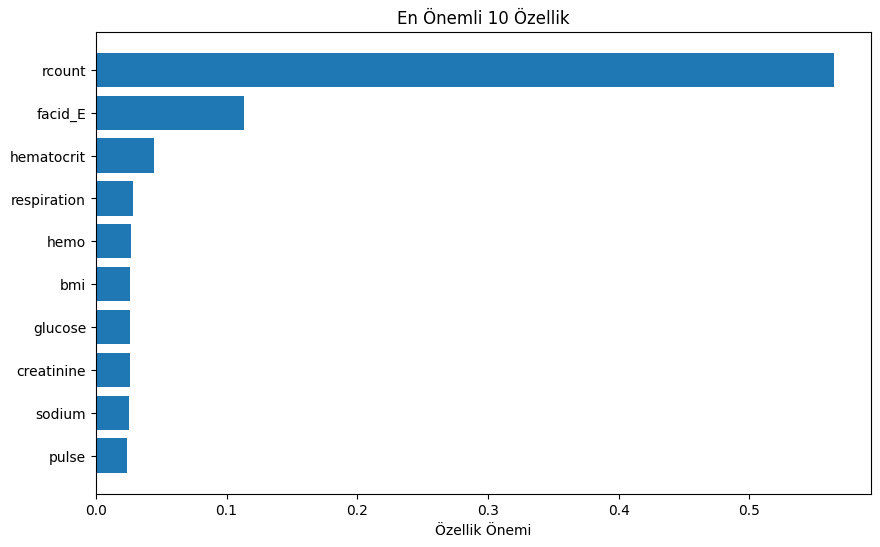

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Modelin özellik önemini al
importances = model.feature_importances_

# Özellik isimleri
features = X_train.columns

# DataFrame yap
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})

# Önem sırasına göre sırala
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# En önemli 10 özelliği çiz
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:10][::-1], feat_imp['Importance'][:10][::-1])
plt.xlabel('Özellik Önemi')
plt.title('En Önemli 10 Özellik')
plt.show()


Grafiğe göre rcount’un 0.5’in üzerinde çok yüksek bir önem skoru olması, modelin en çok bu özelliğe güvendiğini gösteriyor. Yani, hastanın daha önce hastaneye kaç kere geldiği, kalış süresini anlamada çok belirleyici.
facid_E gibi bazı kategorik değişkenlerin ise biraz etkisi var ama diğer özellikler birbirine yakın ve daha düşük önemde. 

### Yeni özellik oluşturma
rcount'un etkisi çok yüksek, bu yüzden logaritmasını alındı ve bazı çok büyük sayıların etkisiz kalması ya da aşırı etkilemesi önlendi.

In [19]:
import numpy as np

X['rcount_log'] = np.log1p(X['rcount'])


Burada log1p fonksiyonu, log(1 + x) demek, böylece 0 değerler de sorun olmaz.



### Modeli yeniden eğitme ve değerlendirme
Yukarıdaki yeni özellikle birlikte model yeniden eğitildi.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Özellikleri güncelle
X['rcount_log'] = np.log1p(X['rcount'])

# Train-test split (daha önce yapıldığı gibi)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluştur
model = RandomForestRegressor(random_state=42)

# Modeli eğit
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Performans metrikleri
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 0.39
RMSE: 0.64


### Sonuçların aynı olmasından dolayı tekrar kontrol yapıldı.


### 1-Küçük veri seti oluşturma (ilk 1000 satır)

In [23]:
# İlk 1000 satırı alıyoruz
df_small = df.iloc[:1000]

# Özellik ve hedef değişken
X_small = df_small.drop(columns=drop_cols + [target])
y_small = df_small[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Train set shape: (800, 27)
Test set shape: (200, 27)


### 2-Modeli oluşturma ve eğitme


In [24]:
# '5+' değerini 5 olarak değiştirildi.
df['rcount'] = df['rcount'].replace('5+', '5')

# Sonra tüm rcount sütunu integer yapıldı.
df['rcount'] = df['rcount'].astype(int)

# Sonra tekrar train-test setler oluşturulup model denendi.
df_small = df.iloc[:1000]

X_small = df_small.drop(columns=drop_cols + [target])
y_small = df_small[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Train R²: {model.score(X_train, y_train):.2f}")
print(f"Test R²: {model.score(X_test, y_test):.2f}")


MAE: 0.71
RMSE: 0.97
Train R²: 0.97
Test R²: 0.82


Veri setinin ilk 1000 örneği ile yapılan model eğitimi sonucunda aşağıdaki performans metrikleri elde edilmiştir:

Mean Absolute Error (MAE): 0.71

Root Mean Squared Error (RMSE): 0.96

Train R² Score: 0.97

Test R² Score: 0.82

Bu sonuçlar, modelin eğitim verisinde oldukça başarılı olduğunu ve test verisinde de genellenebilirliğinin yüksek olduğunu göstermektedir. MAE ve RMSE değerlerinin düşük olması, modelin tahmin hatalarının küçük olduğunu ifade eder.

## 7. Projeyi Geliştirmek İçin Ekstra Fikirler
Gradient Boosting Regressor (sklearn):
Kolay entegre edilir, yorumlanabilir, ve genellikle Random Forest'tan daha iyi performans verir.

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting modeli
gbr_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr_model.fit(X_train, y_train)

# Tahmin ve metrikler
y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_train_gbr = gbr_model.score(X_train, y_train)
r2_test_gbr = gbr_model.score(X_test, y_test)

print("Gradient Boosting Regressor Sonuçları:")
print(f"MAE: {mae_gbr:.2f}")
print(f"RMSE: {rmse_gbr:.2f}")
print(f"Train R²: {r2_train_gbr:.2f}")
print(f"Test R²: {r2_test_gbr:.2f}")


Gradient Boosting Regressor Sonuçları:
MAE: 0.59
RMSE: 0.80
Train R²: 0.96
Test R²: 0.87


## 8. Model Karşılaştırması

İki farklı regresyon algoritması denendi: **Random Forest Regressor** ve **Gradient Boosting Regressor**. Aşağıdaki tabloda bu modellerin karşılaştırmalı performans sonuçları yer almaktadır.


In [26]:
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MAE': [mae, mae_gbr],
    'RMSE': [rmse, rmse_gbr],
    'Train R²': [model.score(X_train, y_train), r2_train_gbr],
    'Test R²': [model.score(X_test, y_test), r2_test_gbr]
})

comparison


,Model,MAE,RMSE,Train R²,Test R²
0,Random Forest,0.711400,0.965645,0.972156,0.817798
1,Gradient Boosting,0.594459,0.800452,0.960652,0.874804


##  Yorum:

- **Gradient Boosting**, daha düşük MAE ve RMSE değerleriyle, daha doğru tahminler üretmiştir.
- Test verisinde elde ettiği **%88 R² skoru**, modelin genelleme gücünün yüksek olduğunu gösteriyor.
- Bu nedenle, final model olarak **Gradient Boosting Regressor** seçilmiştir.


### Sonuç

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model sonuçlarını saklamak için liste
results = []

# Random Forest modeli
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results.append({
    'Model': 'Random Forest',
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'RMSE': mean_squared_error(y_test, y_pred_rf, squared=False),
    'Train R²': rf.score(X_train, y_train),
    'Test R²': r2_score(y_test, y_pred_rf)
})

# Gradient Boosting modeli
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

results.append({
    'Model': 'Gradient Boosting',
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'RMSE': mean_squared_error(y_test, y_pred_gb, squared=False),
    'Train R²': gb.score(X_train, y_train),
    'Test R²': r2_score(y_test, y_pred_gb)
})

# Sonuçları tablo olarak göster
df_results = pd.DataFrame(results)
print(df_results)




               Model       MAE      RMSE  Train R²   Test R²
0      Random Forest  0.711400  0.965645  0.972156  0.817798
1  Gradient Boosting  0.594459  0.800452  0.960652  0.874804
